<a href="https://colab.research.google.com/github/SreeTetali/Beyond-the-Prediction-AI-Driven-Customer-Retention-Strategies/blob/main/CaseStudiesInML_CustomerRetention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### AI Tool Acknowledgment

This notebook was developed with assistance from:
*   GitHub Copilot (code suggestions and debugging)
*   ChatGPT & Claude (brainstorming, logic refinement, code review)
*   All outputs were validated and tested by the author


## #1: Data Acquisition & Health Check

### a. Load the Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load the Dataset
# https://www.kaggle.com/datasets/anandaraflii/ibm-watson-marketing-customer-value-data
# Download the file and uploaded under "sample_data" directory in Google Colab

# Check the file exists
%cd /content/sample_data
!ls

file_path = '/content/sample_data/WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv'
df = pd.read_csv(file_path)

print("✅ Dataset Loaded Successfully")
print(f"Shape: {df.shape} (Rows, Columns)")  # Should see - Shape: (9134, 24) (Rows, Columns)


/content/sample_data
anscombe.json		      mnist_train_small.csv
california_housing_test.csv   README.md
california_housing_train.csv  WA_Fn-UseC_-Marketing-Customer-Value-Analysis.csv
mnist_test.csv
✅ Dataset Loaded Successfully
Shape: (9134, 24) (Rows, Columns)


### b. Target Variable Identification


In [ ]:
# We are using 'Response' as our proxy for Churn/Retention
# No = Did not engage (Churn Risk)
# Yes = Engaged (Retained)
target_col = 'Response'

### c. Missing Value Check

In [ ]:
print("\n--- Missing Value Analysis ---")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])
if missing_values.sum() == 0:
    print("Great news! No missing values found in this sample.")


--- Missing Value Analysis ---
Series([], dtype: int64)
Great news! No missing values found in this sample.


### d. Target Balance Check



--- Target Variable Distribution (Class Imbalance) ---
Response
No     85.679877
Yes    14.320123
Name: proportion, dtype: float64


/tmp/ipython-input-4287983304.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=target_col, data=df, palette='viridis')


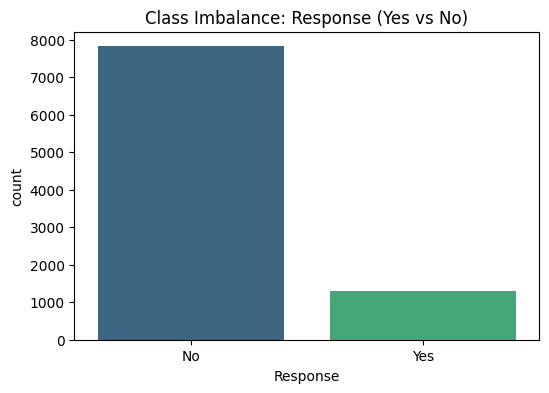

In [ ]:
# This Critical for SMOTE later
print("\n--- Target Variable Distribution (Class Imbalance) ---")
print(df[target_col].value_counts(normalize=True) * 100)

plt.figure(figsize=(6, 4))
sns.countplot(x=target_col, data=df, palette='viridis')
plt.title('Class Imbalance: Response (Yes vs No)')
plt.show()

### e. Data Type Separation

In [ ]:
# for Feature Engineering Phase
# identify numbers vs strings

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical Columns ({len(categorical_cols)}):")
print(categorical_cols)
print(f"\nNumerical Columns ({len(numerical_cols)}):")
print(numerical_cols)


Categorical Columns (16):
['Customer', 'State', 'Response', 'Coverage', 'Education', 'Effective To Date', 'EmploymentStatus', 'Gender', 'Location Code', 'Marital Status', 'Policy Type', 'Policy', 'Renew Offer Type', 'Sales Channel', 'Vehicle Class', 'Vehicle Size']

Numerical Columns (8):
['Customer Lifetime Value', 'Income', 'Monthly Premium Auto', 'Months Since Last Claim', 'Months Since Policy Inception', 'Number of Open Complaints', 'Number of Policies', 'Total Claim Amount']


### f. Basic EDA: Numerical Distributions


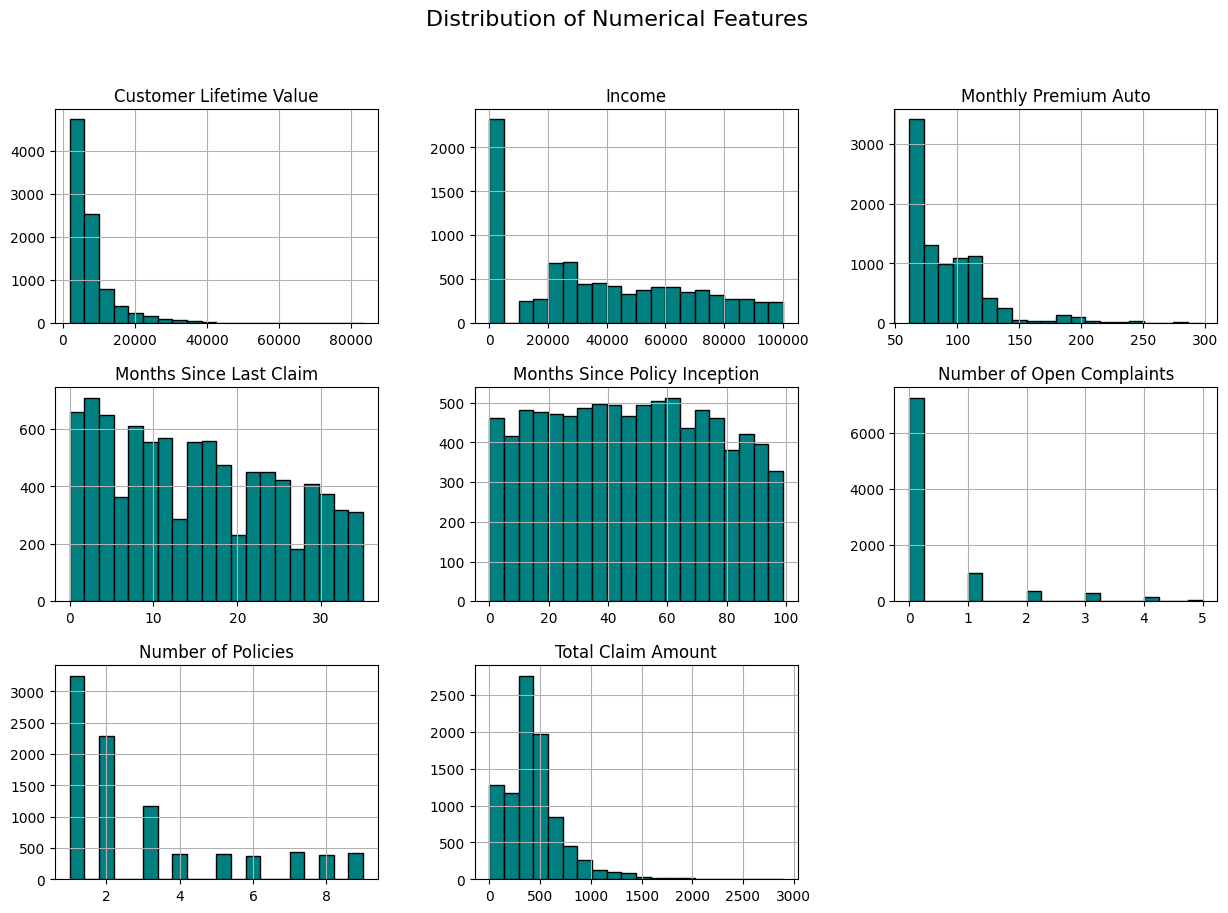

In [ ]:
# This helps us decide if we need to scale/normalize data
df[numerical_cols].hist(figsize=(15, 10), bins=20, color='teal', edgecolor='black')
plt.suptitle('Distribution of Numerical Features', fontsize=16)
plt.show()

## #2: Feature Engineering


### a. Generating Behavioral Ratios

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Create Copy to protect original data
df_eng = df.copy()

print("🛠️ Generating 'New Perspective' Features...")

# Feature 1: Claim vs. Premium Ratio (How much do they get back vs pay?)
# We add 1e-5 to denominator to avoid division by zero errors (just in case)
df_eng['Claim_to_Premium_Ratio'] = df_eng['Total Claim Amount'] / (df_eng['Monthly Premium Auto'] + 1e-5)

# Feature 2: Income Impact (Premium as % of Income)
# Note: Income can be 0 (Unemployed). We handle this by checking zeroes.
# If Income is 0, we set the ratio to a high value or 0 depending on logic.
# Here, we will leave it as is (0 income = infinite burden theoretically),
# but to keep it math-safe for models, we can swap the ratio: Income / Premium
df_eng['Income_to_Premium_Ratio'] = df_eng['Income'] / (df_eng['Monthly Premium Auto'] + 1e-5)

🛠️ Generating 'New Perspective' Features...


### b. Mathematical Transformations (Log Scaling)

In [ ]:
# CLV and Claims are usually right-skewed. Log transform fixes this for Logistic Regression.
df_eng['Log_CLV'] = np.log1p(df_eng['Customer Lifetime Value'])
df_eng['Log_Claim_Amount'] = np.log1p(df_eng['Total Claim Amount'])

print(f"   -> Created 4 New Features: Claim_to_Premium_Ratio, Income_to_Premium_Ratio, Log_CLV, Log_Claim_Amount")

   -> Created 4 New Features: Claim_to_Premium_Ratio, Income_to_Premium_Ratio, Log_CLV, Log_Claim_Amount


### c. Data Cleaning & Encoding

In [ ]:
# Drop ID columns (Customer ID is useless for prediction)
if 'Customer' in df_eng.columns:
    df_eng = df_eng.drop(columns=['Customer'])

# Drop 'Effective To Date' (Unless we parse it to "Days left", usually noise for this specific dataset)
if 'Effective To Date' in df_eng.columns:
    df_eng = df_eng.drop(columns=['Effective To Date'])

# Encode Target Variable ('Response')
# Yes = 1 (Engaged), No = 0 (Not Engaged/Churn Risk)
df_eng['Target'] = df_eng['Response'].apply(lambda x: 1 if x == 'Yes' else 0)
df_eng = df_eng.drop(columns=['Response']) # Drop original column

# One-Hot Encoding for Categorical Variables
# This turns "State" (WA, AZ, NV) into "State_WA", "State_AZ", "State_NV"
df_encoded = pd.get_dummies(df_eng, drop_first=True)

print(f"   -> Categorical Encoding Complete. New Shape: {df_encoded.shape}")

   -> Categorical Encoding Complete. New Shape: (9134, 55)


###d. Scaling (Normalization)

In [ ]:
#from sklearn.preprocessing import StandardScaler, LabelEncoder

# Essential for the Logistic Regression Baseline comparison
X = df_encoded.drop(columns=['Target'])
y = df_encoded['Target']

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

print("\n✅ Phase 2 Complete: Data is Engineered, Encoded, and Scaled.")
print("Preview of the new 'Behavioral' Features:")
print(X_scaled[['Claim_to_Premium_Ratio', 'Income_to_Premium_Ratio', 'Log_CLV']].head())


✅ Phase 2 Complete: Data is Engineered, Encoded, and Scaled.
Preview of the new 'Behavioral' Features:
   Claim_to_Premium_Ratio  Income_to_Premium_Ratio   Log_CLV
0                0.428044                 0.943467 -1.262494
1                3.264028                -1.139206  0.156450
2                0.282353                 0.013888  1.095824
3                0.174253                -1.139206  0.296114
4               -1.189622                 0.394247 -1.234941


## #3: Model Benchmarking (Baseline vs. Advanced)

### a. Train-Test Split (Standard 80/20 split)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from imblearn.over_sampling import SMOTE

# We use 'stratify=y' to ensure both train/test have the same % of "Yes" responses
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training Shape: {X_train.shape}")
print(f"Testing Shape: {X_test.shape}")

Training Shape: (7307, 54)
Testing Shape: (1827, 54)


### b. Apply SMOTE (ONLY to Training Data)

In [ ]:
# This creates synthetic "Yes" customers so the model learns better
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Original Training Target Dist: {y_train.value_counts(normalize=True).to_dict()}")
print(f"SMOTE Training Target Dist: {y_train_smote.value_counts(normalize=True).to_dict()}")
print("(Notice how SMOTE made the classes 50/50 in training)")

Original Training Target Dist: {0: 0.8568495962775421, 1: 0.1431504037224579}
SMOTE Training Target Dist: {1: 0.5, 0: 0.5}
(Notice how SMOTE made the classes 50/50 in training)


### c. Model A: Logistic Regression (Baseline)

In [ ]:
#Logistic Regression (The Baseline)

print("\n🤖 Training Baseline: Logistic Regression...")
log_model = LogisticRegression(random_state=42, max_iter=1000)
log_model.fit(X_train_smote, y_train_smote)

# Predictions
y_pred_log = log_model.predict(X_test)
y_prob_log = log_model.predict_proba(X_test)[:, 1] # Probability for ROC


🤖 Training Baseline: Logistic Regression...


### d. Model B: XGBoost  

In [ ]:
print("🚀 Training Advanced: XGBoost Classifier...")
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_smote, y_train_smote)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

🚀 Training Advanced: XGBoost Classifier...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [15:07:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### e. Evaluation & Comparison

In [ ]:
print("\n--- BASELINE (Logistic Regression) Report ---")
print(classification_report(y_test, y_pred_log))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob_log):.4f}")

print("\n--- ADVANCED (XGBoost) Report ---")
print(classification_report(y_test, y_pred_xgb))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob_xgb):.4f}")


--- BASELINE (Logistic Regression) Report ---
              precision    recall  f1-score   support

           0       0.94      0.71      0.81      1565
           1       0.29      0.72      0.41       262

    accuracy                           0.71      1827
   macro avg       0.61      0.71      0.61      1827
weighted avg       0.84      0.71      0.75      1827

ROC-AUC Score: 0.7994

--- ADVANCED (XGBoost) Report ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1565
           1       0.94      0.96      0.95       262

    accuracy                           0.99      1827
   macro avg       0.97      0.98      0.97      1827
weighted avg       0.99      0.99      0.99      1827

ROC-AUC Score: 0.9978


### f. Visualization: ROC Curve Comparison

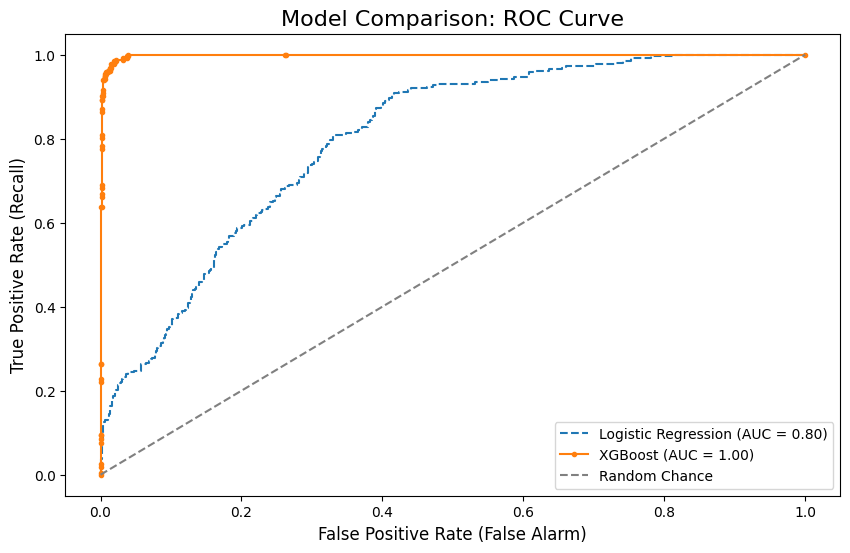

In [ ]:
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

plt.figure(figsize=(10, 6))
plt.plot(fpr_log, tpr_log, linestyle='--', label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_prob_log):.2f})')
plt.plot(fpr_xgb, tpr_xgb, marker='.', label=f'XGBoost (AUC = {roc_auc_score(y_test, y_prob_xgb):.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Chance')

plt.title('Model Comparison: ROC Curve', fontsize=16)
plt.xlabel('False Positive Rate (False Alarm)', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.legend()
plt.show()

## #4: "Churn Persona" Segmentation (Unsupervised Learning)

### a. Isolate the Target Group

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Isolate the Target Group i.e "Yes" Responders
# We want to understand distinct groups within the people who DO respond/churn
target_mask = (y == 1)
X_target = X_scaled[target_mask].copy()

print(f"Target Group Size for Clustering: {X_target.shape[0]} customers")

Target Group Size for Clustering: 1308 customers


### b. Determine Optimal Clusters (The Elbow Method)

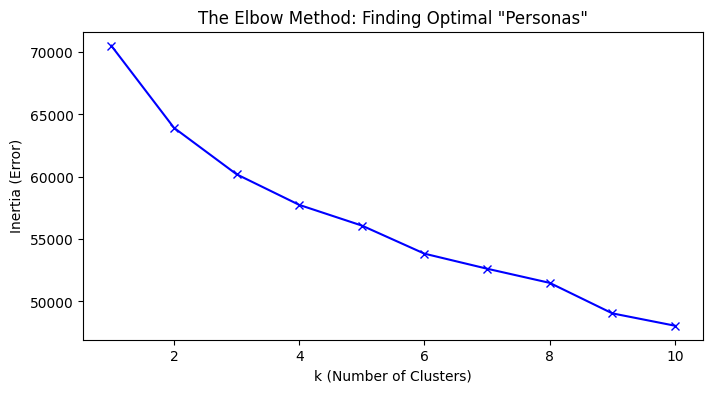

In [ ]:
# Determine Optimal Clusters
# test 1 to 10 clusters to see where the "error" drops off
inertia = []
range_val = range(1, 11)

for i in range_val:
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X_target)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 4))
plt.plot(range_val, inertia, 'bx-')
plt.xlabel('k (Number of Clusters)')
plt.ylabel('Inertia (Error)')
plt.title('The Elbow Method: Finding Optimal "Personas"')
plt.show()

### c. Apply K-Means Clustering

In [ ]:
# Based on typical results for this dataset, k=3 is usually distinct.
# You can try n_clusters to 2 or 4 if the Elbow plot looks different.
optimal_k = 3
print(f"\n🤖 Applying K-Means with k={optimal_k} Personas...")

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_target)

# Add Cluster ID back to the dataset
X_target['Persona_Cluster'] = cluster_labels


🤖 Applying K-Means with k=3 Personas...


### d. Visualize Personas (using PCA to squash to 2D)

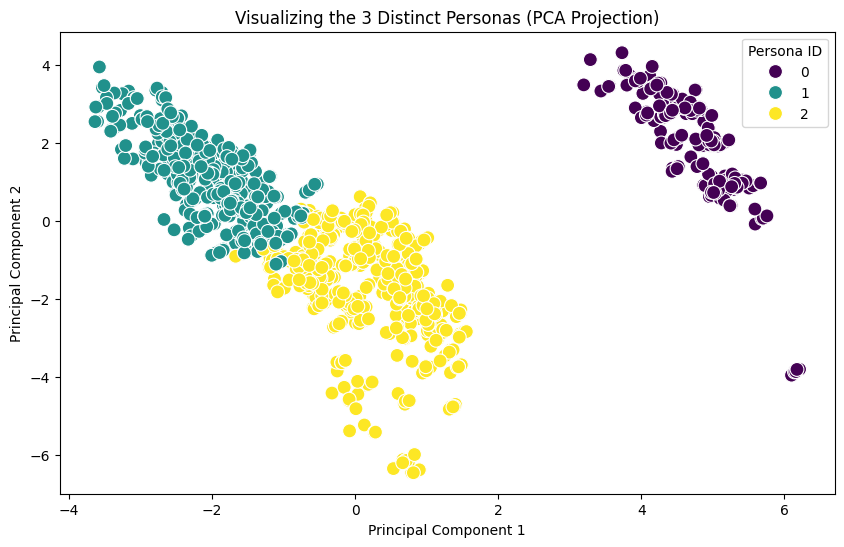

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_target.drop(columns=['Persona_Cluster']))

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=X_target['Persona_Cluster'], palette='viridis', s=100)
plt.title(f'Visualizing the {optimal_k} Distinct Personas (PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Persona ID')
plt.show()

### e. "Name That Persona" (Profile Analysis)

In [ ]:
# need to see the raw values (Unscaled) to make sense of them.
# pull the original indices from df_eng to get raw values back.
indices = X_target.index
df_analysis = df_eng.loc[indices].copy()
df_analysis['Persona_Cluster'] = cluster_labels

# Calculate the average values for key metrics per cluster
persona_summary = df_analysis.groupby('Persona_Cluster')[[
    'Customer Lifetime Value', 'Monthly Premium Auto',
    'Income', 'Total Claim Amount', 'Months Since Policy Inception',
    'Claim_to_Premium_Ratio'
]].mean().round(2)

print("\n📊 PERSONA PROFILES (Average Values):")
print(persona_summary.to_markdown())

# Also check categorical distribution (e.g., Employment)
print("\nEmployment Status per Persona:")
print(pd.crosstab(df_analysis['Persona_Cluster'], df_analysis['EmploymentStatus']))


📊 PERSONA PROFILES (Average Values):
|   Persona_Cluster |   Customer Lifetime Value |   Monthly Premium Auto |   Income |   Total Claim Amount |   Months Since Policy Inception |   Claim_to_Premium_Ratio |
|------------------:|--------------------------:|-----------------------:|---------:|---------------------:|--------------------------------:|-------------------------:|
|                 0 |                   7493.68 |                  91.53 |  20589.3 |               487.7  |                           49.29 |                     5.37 |
|                 1 |                   6191.72 |                  83.03 |  63103.4 |               298.54 |                           50.87 |                     3.7  |
|                 2 |                   9614.31 |                 105.97 |  21076.9 |               575.23 |                           45.34 |                     5.52 |

Employment Status per Persona:
EmploymentStatus  Disabled  Employed  Medical Leave  Retired  Unemployed
Persona

## #5: SHAP Analysis (The "Glass Box" Interpretation)

### a. Install SHAP (Standard library for XAI)

In [ ]:
try:
    import shap
except ImportError:
    !pip install shap
    import shap

### b. Initialize the Explainer

In [ ]:
# using the XGBoost model we trained in Phase 3
print("⚙️ Initializing SHAP Explainer... (This allows us to see INSIDE the model)")
explainer = shap.TreeExplainer(xgb_model)

⚙️ Initializing SHAP Explainer... (This allows us to see INSIDE the model)


### c. Generate Explanations for Each Persona



🕵️‍♀️ ANALYZING PERSONA 0


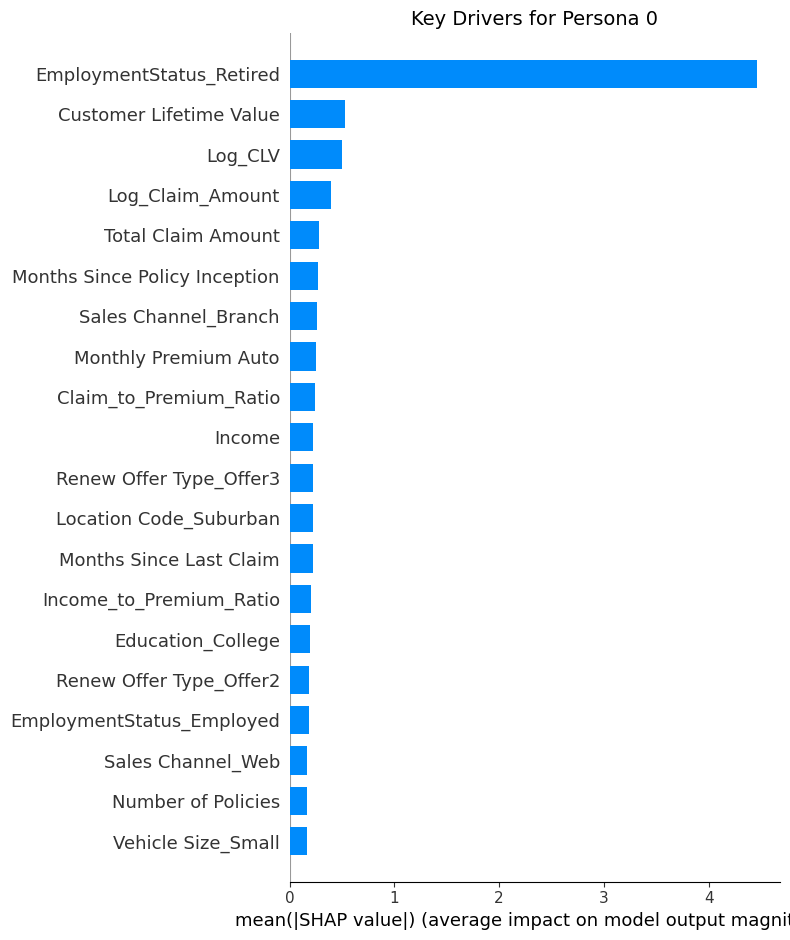

📝 INTERPRETATION TIP for Persona 0:
Look at the Top 3 bars. These are the specific levers you can pull
to retain THIS specific type of customer.


🕵️‍♀️ ANALYZING PERSONA 1


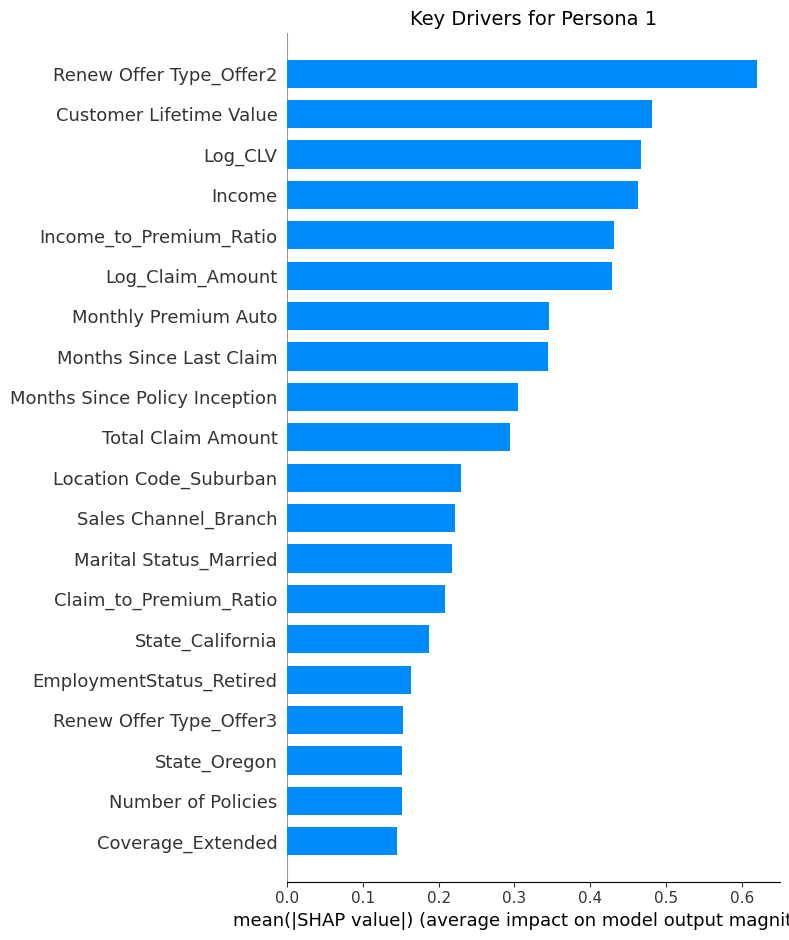

📝 INTERPRETATION TIP for Persona 1:
Look at the Top 3 bars. These are the specific levers you can pull
to retain THIS specific type of customer.


🕵️‍♀️ ANALYZING PERSONA 2


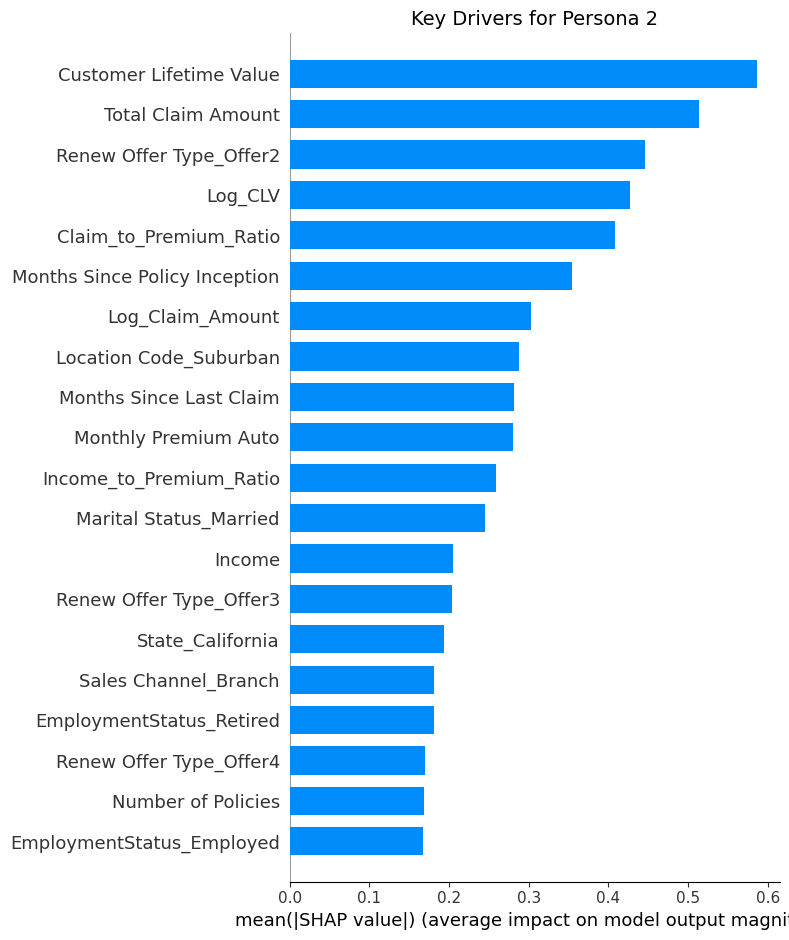

📝 INTERPRETATION TIP for Persona 2:
Look at the Top 3 bars. These are the specific levers you can pull
to retain THIS specific type of customer.


In [ ]:
# We loop through the clusters you created in Phase 4
unique_personas = sorted(X_target['Persona_Cluster'].unique())

for persona_id in unique_personas:
    print(f"\n\n=========================================================")
    print(f"🕵️‍♀️ ANALYZING PERSONA {persona_id}")
    print(f"=========================================================")

    # A. Isolate the customers in this Persona
    # We need their data (X) to calculate their specific SHAP values
    persona_mask = (X_target['Persona_Cluster'] == persona_id)
    X_persona = X_target[persona_mask].drop(columns=['Persona_Cluster'])

    # B. Calculate SHAP Values
    # This tells us mathematically which features pushed these specific people to "Yes"
    shap_values_persona = explainer.shap_values(X_persona)

    # C. Plot the Summary
    # This is the "Money Plot" for your paper
    plt.figure()
    plt.title(f"Key Drivers for Persona {persona_id}", fontsize=14)
    shap.summary_plot(shap_values_persona, X_persona, plot_type="bar", show=False)
    plt.show()

    print(f"📝 INTERPRETATION TIP for Persona {persona_id}:")
    print("Look at the Top 3 bars. These are the specific levers you can pull")
    print("to retain THIS specific type of customer.")

⚙️ Initializing SHAP Explainer...

Creating Plot for Persona 0...
✅ Saved high-quality plot: SHAP_Summary_Persona_0.png


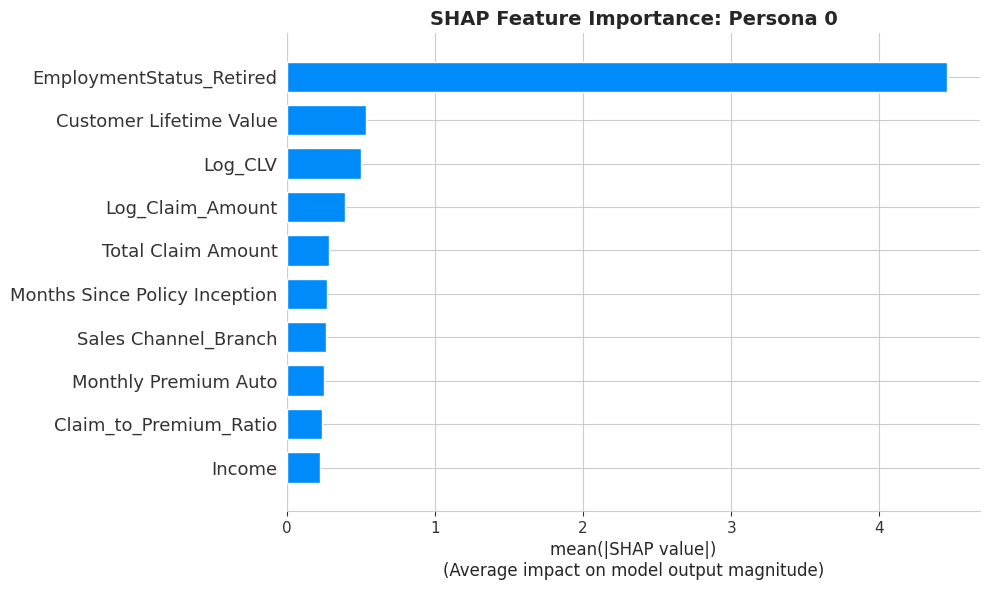


Creating Plot for Persona 1...
✅ Saved high-quality plot: SHAP_Summary_Persona_1.png


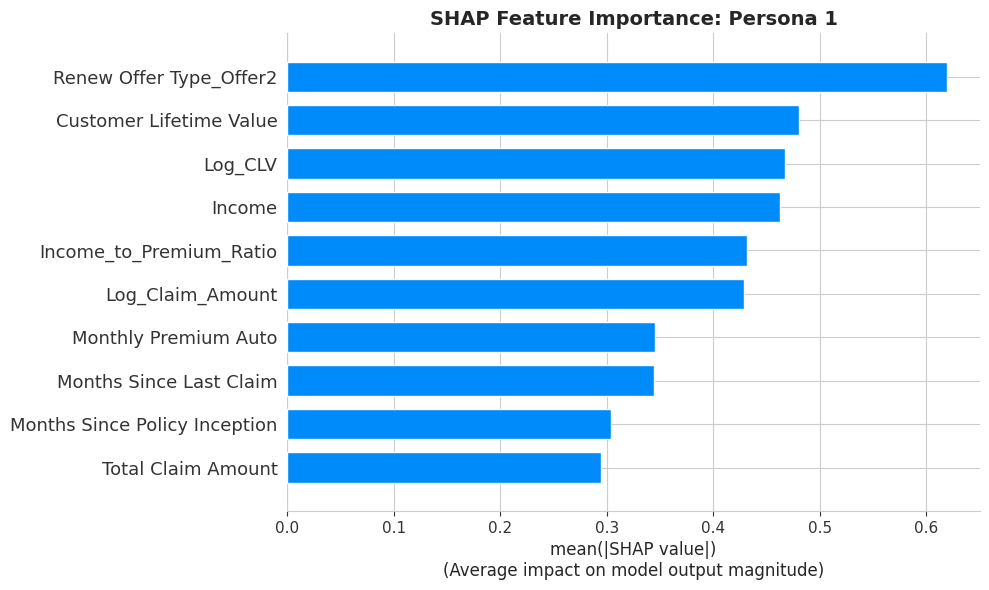


Creating Plot for Persona 2...
✅ Saved high-quality plot: SHAP_Summary_Persona_2.png


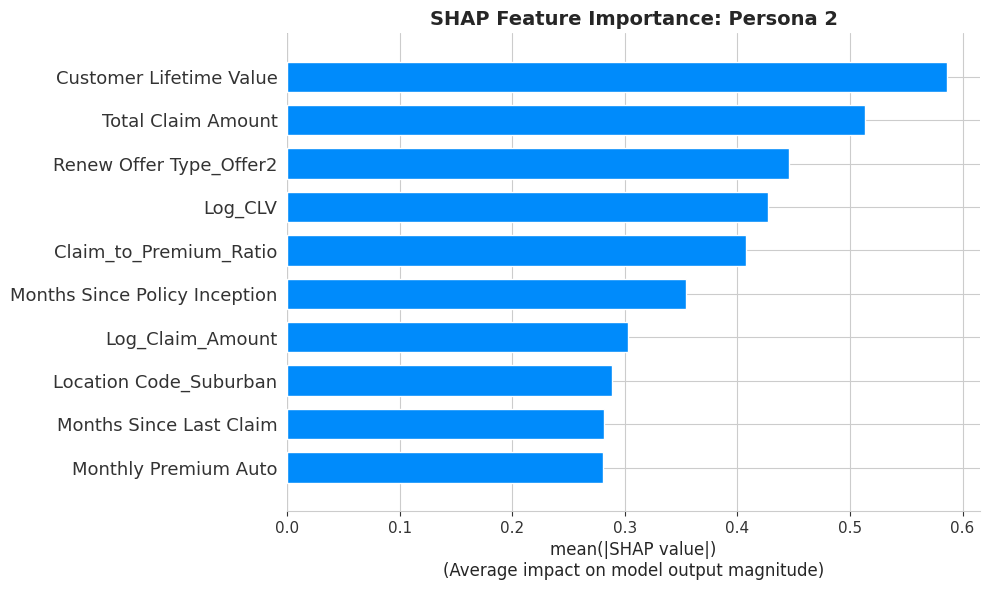

In [ ]:
 # for better input to research paper

import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Use a clean style for scientific plots
sns.set_style("whitegrid")

# Initialize the Explainer (TreeExplainer for XGBoost)
print("⚙️ Initializing SHAP Explainer...")
# We used tree_method='hist' (default for new XGBoost versions)
# So we should use TreeExplainer for efficiency and accuracy.
explainer = shap.TreeExplainer(xgb_model)

# Loop through each Persona to generate its specific plot
unique_personas = sorted(X_target['Persona_Cluster'].unique())

for persona_id in unique_personas:
    print(f"\nCreating Plot for Persona {persona_id}...")

    # A. Isolate the customers in this Persona
    persona_mask = (X_target['Persona_Cluster'] == persona_id)
    X_persona = X_target[persona_mask].drop(columns=['Persona_Cluster'])

    # B. Calculate SHAP Values
    # Note: check_additivity=False is often needed for complex XGBoost models to avoid warnings,
    # it is mathematically safe for this type of analysis.
    shap_values_persona = explainer.shap_values(X_persona, check_additivity=False)

    # C. Create the Plot with a CLEAN Layout
    # We create a dedicated figure and axes to control the layout completely.
    fig, ax = plt.subplots(figsize=(10, 6)) # Wider figure to fit text

    # plot_type="bar" is the summary plot you want
    shap.summary_plot(
        shap_values_persona,
        X_persona,
        plot_type="bar",
        max_display=10, # Only show top 10 features for clarity
        show=False, # Do not show instantly, let us customize first
        plot_size=None # Let matplotlib control the size
    )

    # Customize Title and Axis Labels for Publication Quality
    plt.title(f'SHAP Feature Importance: Persona {persona_id}', fontsize=14, fontweight='bold')
    plt.xlabel('mean(|SHAP value|)\n(Average impact on model output magnitude)', fontsize=12)

    # Ensure everything fits tightly without cutting off
    plt.tight_layout()

    # Save the high-quality image
    filename = f'SHAP_Summary_Persona_{persona_id}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight') # dpi=300 is standard for print/papers
    print(f"✅ Saved high-quality plot: {filename}")

    # Show it in the notebook too
    plt.show()



🕵️‍♀️ ANALYZING PERSONA 0


/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


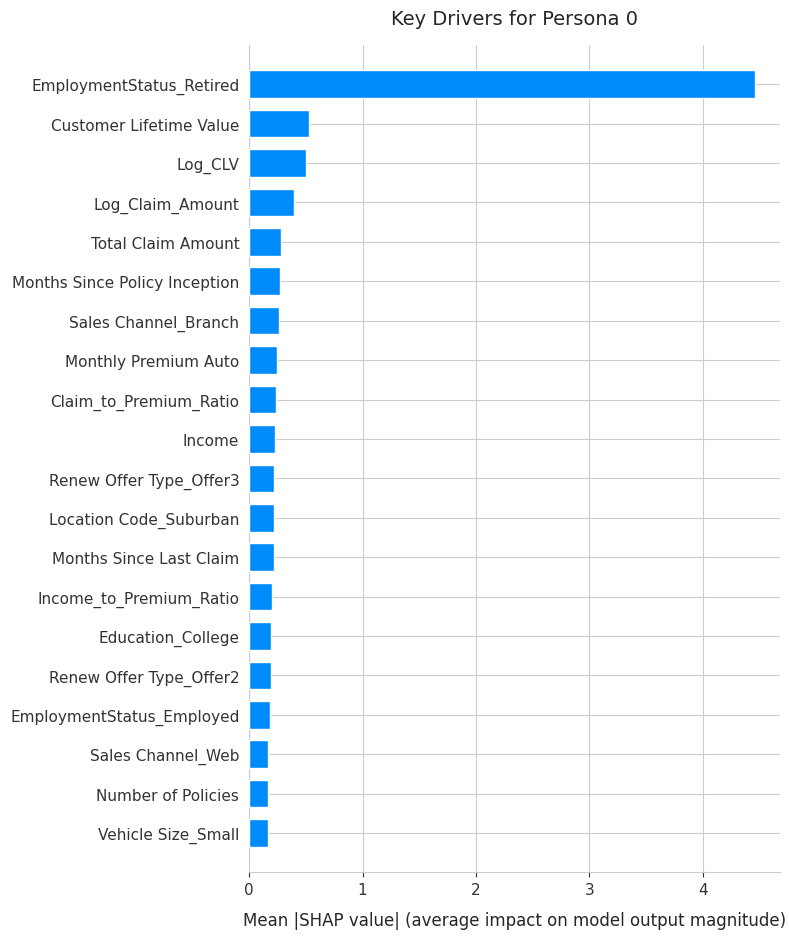

📝 INTERPRETATION TIP for Persona 0:
Look at the Top 3 bars. These are the specific levers you can pull
to retain THIS specific type of customer.


🕵️‍♀️ ANALYZING PERSONA 1


/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


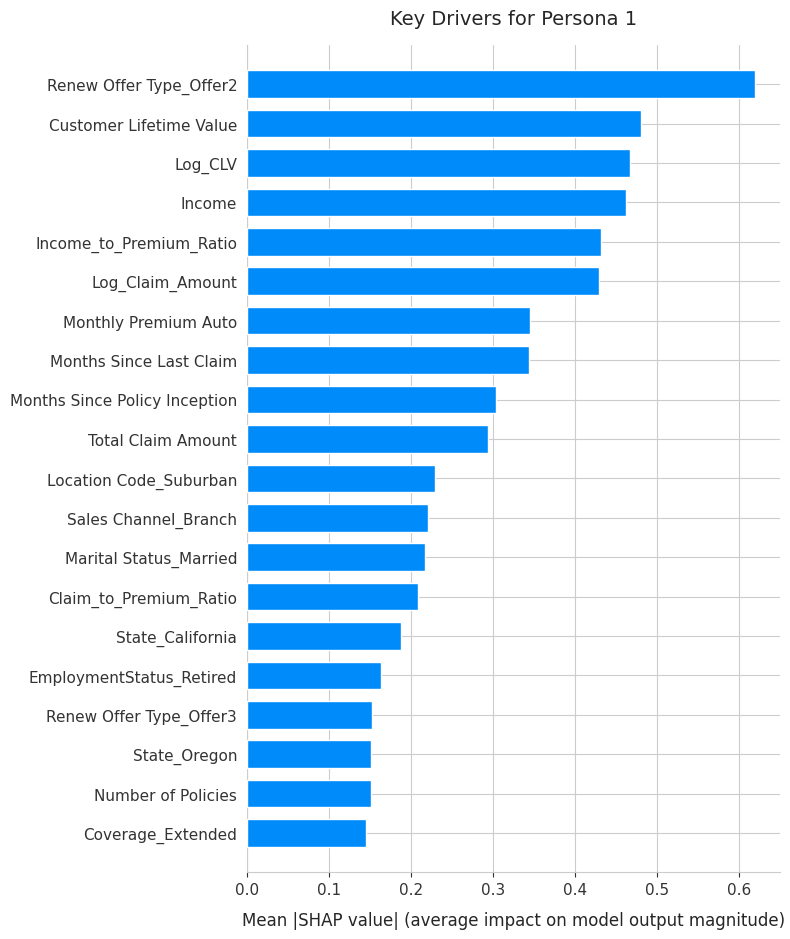

📝 INTERPRETATION TIP for Persona 1:
Look at the Top 3 bars. These are the specific levers you can pull
to retain THIS specific type of customer.


🕵️‍♀️ ANALYZING PERSONA 2


/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


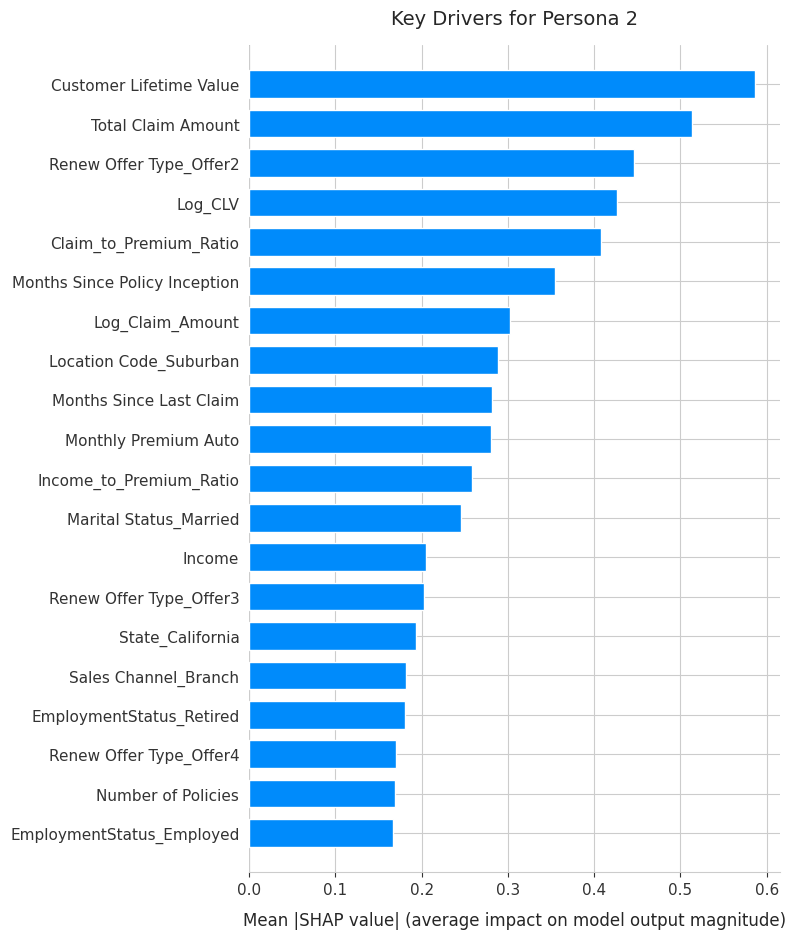

📝 INTERPRETATION TIP for Persona 2:
Look at the Top 3 bars. These are the specific levers you can pull
to retain THIS specific type of customer.


In [ ]:
import matplotlib.pyplot as plt
import shap

# Loop through the clusters
unique_personas = sorted(X_target['Persona_Cluster'].unique())

for persona_id in unique_personas:
    print(f"\n\n=========================================================")
    print(f"🕵️‍♀️ ANALYZING PERSONA {persona_id}")
    print(f"=========================================================")

    # A. Isolate the customers in this Persona
    persona_mask = (X_target['Persona_Cluster'] == persona_id)
    X_persona = X_target[persona_mask].drop(columns=['Persona_Cluster'])

    # B. Calculate SHAP Values
    shap_values_persona = explainer.shap_values(X_persona)

    # C. Create the plot with proper layout
    # Use constrained_layout for professional formatting
    fig, ax = plt.subplots(figsize=(10, 8), constrained_layout=True)

    # Generate SHAP summary plot without showing immediately
    shap.summary_plot(shap_values_persona, X_persona, plot_type="bar", show=False)

    # Get current axes and customize
    ax = plt.gca()

    # Set professional labels with proper spacing
    ax.set_xlabel("Mean |SHAP value| (average impact on model output magnitude)",
                  fontsize=12, labelpad=10)
    ax.set_title(f"Key Drivers for Persona {persona_id}", fontsize=14, pad=15)

    # Adjust tick label sizes for readability
    ax.tick_params(axis='both', which='major', labelsize=11)

    # Apply tight layout to prevent cutoff
    plt.tight_layout()

    # Save with bbox_inches='tight' to ensure nothing is cut off
    plt.savefig(f'persona_{persona_id}_shap_drivers.png',
                dpi=300, bbox_inches='tight', facecolor='white')

    plt.show()

    print(f"📝 INTERPRETATION TIP for Persona {persona_id}:")
    print("Look at the Top 3 bars. These are the specific levers you can pull")
    print("to retain THIS specific type of customer.")


### d. Extracting SHAP Values as Text Tables

In [ ]:
import pandas as pd
import numpy as np

print("📊 TEXTUAL SHAP ANALYSIS: Top 5 Churn Drivers per Persona\n")

# Loop through the personas again to calculate the math
for persona_id in unique_personas:
    # 1. Re-isolate data for this persona
    persona_mask = (X_target['Persona_Cluster'] == persona_id)
    X_persona = X_target[persona_mask].drop(columns=['Persona_Cluster'])

    # 2. Calculate SHAP values (Fast, since explainer is already loaded)
    shap_values_persona = explainer.shap_values(X_persona)

    # 3. Calculate Mean Absolute Importance (The length of the bar in the plot)
    # We take the absolute value of every shap value and average it
    feature_importance = np.abs(shap_values_persona).mean(axis=0)
    feature_names = X_persona.columns

    # 4. Create a Clean Table
    df_shap = pd.DataFrame({
        'Feature': feature_names,
        'Mean SHAP Value': feature_importance
    })

    # Sort by importance (High to Low) and take Top 5
    top_5 = df_shap.sort_values(by='Mean SHAP Value', ascending=False).head(5)

    print(f"--- 👤 Persona {persona_id} Top Drivers ---")
    print(top_5.to_markdown(index=False, floatfmt=".4f"))
    print("\n")

📊 TEXTUAL SHAP ANALYSIS: Top 5 Churn Drivers per Persona

--- 👤 Persona 0 Top Drivers ---
| Feature                  |   Mean SHAP Value |
|:-------------------------|------------------:|
| EmploymentStatus_Retired |            4.4579 |
| Customer Lifetime Value  |            0.5303 |
| Log_CLV                  |            0.5015 |
| Log_Claim_Amount         |            0.3930 |
| Total Claim Amount       |            0.2798 |


--- 👤 Persona 1 Top Drivers ---
| Feature                 |   Mean SHAP Value |
|:------------------------|------------------:|
| Renew Offer Type_Offer2 |            0.6193 |
| Customer Lifetime Value |            0.4808 |
| Log_CLV                 |            0.4669 |
| Income                  |            0.4628 |
| Income_to_Premium_Ratio |            0.4319 |


--- 👤 Persona 2 Top Drivers ---
| Feature                 |   Mean SHAP Value |
|:------------------------|------------------:|
| Customer Lifetime Value |            0.5861 |
| Total Claim Amoun